In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 18) 
matplotlib.rc('ytick', labelsize = 18)

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34647,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34311,Total threads: 4
Dashboard: /proxy/33259/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40659,


In [2]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_param_kpp_extended2'

In [3]:
rho0 = 1026
st = '2000-01-01'
et = '2009-12-31'

## Creating a mask

Now we know that SSH is a better diagnostic for our contour mapping because:
1. Contours using SSH are more smooth, and
2. SSH is representative of the gyre extent.

We apply the following boundary conditions to our plot:
1. Everything after 47 degrees N/S must be negative.
2. Everything less than 40 degrees N/S must be positive.
3. In NP, SSH > 0.05 m for positive value.
4. In SP and IO, SSH > 0 m for positive value.
5. In SP and IO, every value equatorward of 46 degrees S must be positive.
6. In SA, SSH > -0.2 m for positive value.
7. In NA, SSH > -0.3 m for positive value. 

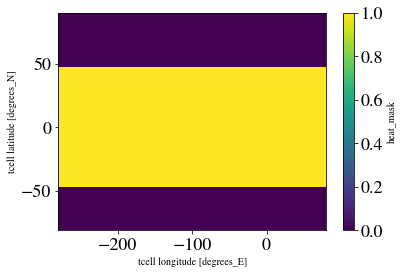

In [4]:
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

SSH = cc.querying.getvar(expt = expt, session = session, variable = 'sea_level', frequency = '1 monthly').sel(time = slice(st, et))
SSH = SSH.mean('time')

mask = np.ones((1080, 1440))
mask_init = xr.DataArray(mask, coords = [geolat_t.yt_ocean, geolat_t.xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'heat_mask', attrs = {'units':'none'})

#temp = cc.querying.getvar(expt = expt, session = session, variable = 'temp', n = 1)
#temp = temp.isel(time = 0).isel(st_ocean = 0)
#mask_land = temp/temp

mask_land1 = mask_init.where(abs(mask_init.yt_ocean) < 47, 0)
mask_land2 = mask_init.where(mask_init.yt_ocean > -47, 0)
mask_land3 = mask_init.where(mask_init.yt_ocean > 47, 0)
mask_land = mask_land1 + mask_land2 - mask_land3

## Changed xr.ufuncs() to np. because xarray ufuncs() is deprecated.
mask_land = np.sign(mask_land)
mask_land.plot()

In [5]:
area_t = cc.querying.getvar(expt = expt, session = session, variable = 'area_t', n = -1)
T = cc.querying.getvar(expt = expt, session = session, variable = 'temp', n = -1)
T = T.isel(st_ocean = 1).isel(time = 1)
area_t = (area_t*T)/T

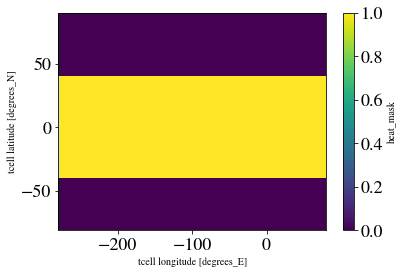

In [6]:
mask_alltrue1 = mask_init.where(abs(mask_init.yt_ocean) < 40, 0)
mask_alltrue2 = mask_init.where(mask_init.yt_ocean > -40, 0)
mask_alltrue3 = mask_init.where(mask_init.yt_ocean > 40, 0)
mask_alltrue = mask_alltrue1 + mask_alltrue2 - mask_alltrue3
mask_alltrue = np.sign(mask_alltrue)
mask_alltrue.plot()

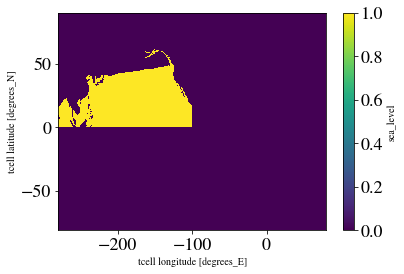

In [7]:
SSH_NPacific = SSH.where(SSH.xt_ocean < -100)
SSH_NPacific = SSH_NPacific.where(SSH.yt_ocean > 0)
mask_NPacific = xr.where(SSH_NPacific > 0.05, 1, 0)
mask_NPacific.plot()

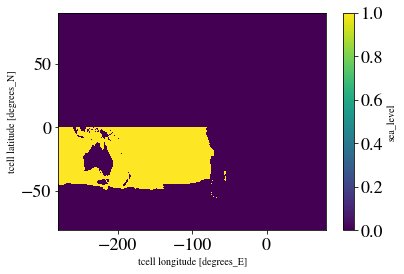

In [8]:
SSH_SPacific = SSH.where(SSH.xt_ocean < -55)
SSH_SPacific = SSH_SPacific.where(SSH.yt_ocean < 0)
mask_SPacific = xr.where(SSH_SPacific > 0.0, 1, 0)
mask_SPacific.plot()

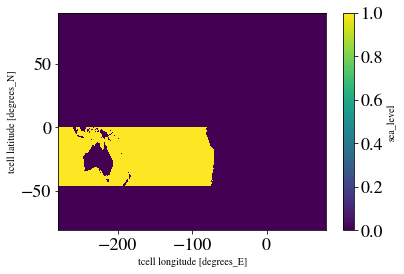

In [9]:
SSH_SP_correction = SSH.where(SSH.xt_ocean < -70)
#SSH_SP_correction = SSH_SP_correction.where(SSH.xt_ocean > -220)
SSH_SP_correction = SSH_SP_correction.where(SSH.yt_ocean < 0)
SSH_SP_correction = SSH_SP_correction.where(SSH.yt_ocean > -46)
mask_SP_correction = xr.where(SSH_SP_correction > -1, 1, 0)
mask_SP_correction.plot()

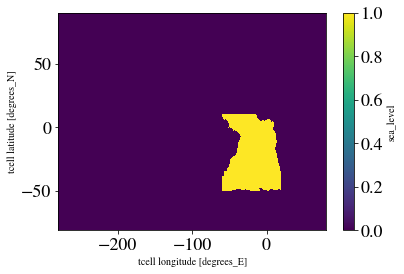

In [10]:
SSH_SA_correction = SSH.where(SSH.xt_ocean > -60)
SSH_SA_correction = SSH_SA_correction.where(SSH.xt_ocean < 20)
SSH_SA_correction = SSH_SA_correction.where(SSH.yt_ocean < 10)
SSH_SA_correction = SSH_SA_correction.where(SSH.yt_ocean > -50)
mask_SA_correction = xr.where(SSH_SA_correction > -1, 1, 0)
mask_SA_correction.plot()

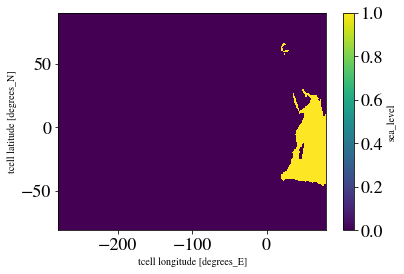

In [11]:
SSH_Indian = SSH.where(SSH.xt_ocean > 20)
mask_Indian = xr.where(SSH_Indian > 0.0, 1, 0)
mask_Indian.plot()

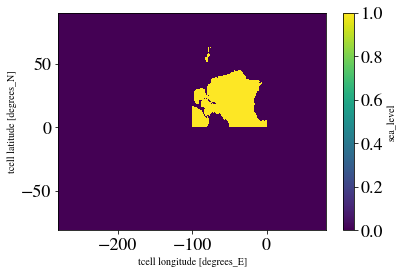

In [12]:
SSH_NAtlantic = SSH.where(SSH.xt_ocean > -100)
SSH_NAtlantic = SSH_NAtlantic.where(SSH.xt_ocean < 0)
SSH_NAtlantic = SSH_NAtlantic.where(SSH.yt_ocean > 0)
mask_NAtlantic = xr.where(SSH_NAtlantic > -0.3, 1, 0)
mask_NAtlantic.plot()

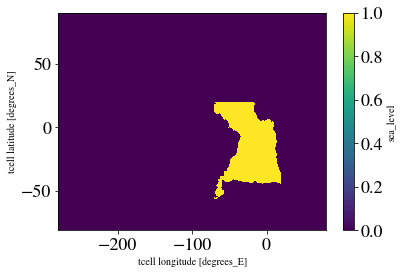

In [13]:
SSH_SAtlantic = SSH.where(SSH.xt_ocean > -70)
SSH_SAtlantic = SSH_SAtlantic.where(SSH.xt_ocean < 20)
SSH_SAtlantic = SSH_SAtlantic.where(SSH.yt_ocean < 20)
mask_SAtlantic = xr.where(SSH_SAtlantic > -0.2, 1, 0)
mask_SAtlantic.plot()

In [14]:
mask_heat = (mask_NAtlantic + mask_SAtlantic * mask_SA_correction + mask_NPacific + mask_SPacific + mask_SP_correction + mask_Indian + mask_alltrue) * mask_land
mask_heat = xr.where(mask_heat > 0.0, 1, -1)
#mask_heat = mask_heat.interp(yt_ocean.)

Text(0.5, 1.0, 'Heat flux mask')

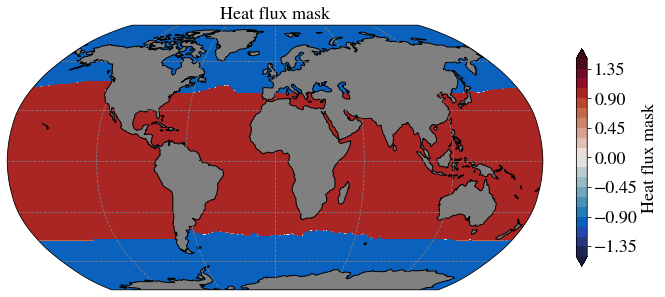

In [15]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1.5, 1.5, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, mask_heat, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Heat flux mask', size = 18)
ax.set_title('Heat flux mask', size = 18)

#plt.savefig('Figures/heat_map.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

## Interpolating values at the junction of +-1 of the mask using tanh function

In [71]:
h_max = 0.495
h_min = -1

In [72]:
mask_heat = (mask_NAtlantic + mask_SAtlantic * mask_SA_correction + mask_NPacific + mask_SPacific + mask_SP_correction + mask_Indian + mask_alltrue) * mask_land
mask_heat = xr.where(mask_heat > 0.0, h_max, h_min)
mask_heat_old = mask_heat.values
mask_heat_new = mask_heat.values

In [73]:
xt = np.arange(0, 1440)
yt = np.arange(0, 1080)

Y, X = np.meshgrid(yt,xt)

In [74]:
dy = 12

start_lat = 100

range_lat = 50
i = range_lat
j = 0

mask_heat_new = mask_heat.values
mask_heat_new = mask_heat_new.astype(np.float)

pos_val = mask_heat.max().values
neg_val = -1.0

while j < 1440:
    i = start_lat
    while i < 1080 - start_lat:
        if((mask_heat_new[i, j]!=mask_heat_new[i+1,j]) and (mask_heat_new[i,j] == pos_val or mask_heat_new[i,j] == neg_val) and (mask_heat_new[i+1,j] == pos_val or mask_heat_new[i+1,j] == neg_val)):
            if(mask_heat_new[i,j] == pos_val and mask_heat_new[i+1,j] == neg_val):
                temp = int(i + range_lat/2)
                mask_heat_new[i:temp, j] = 1
                mask_heat_new[temp-range_lat:temp+range_lat,j] = np.tanh((-yt[i-range_lat:i+range_lat] + i)/dy) * (pos_val - neg_val)/2 + (neg_val + (pos_val - neg_val)/2)
                i = i + 50
            elif(mask_heat_new[i,j] == neg_val and mask_heat_new[i+1,j] == pos_val):
                temp = int(i - range_lat/2)
                mask_heat_new[temp-range_lat:temp+range_lat,j] = np.tanh((yt[i-range_lat:i+range_lat] - i)/dy) * (pos_val - neg_val)/2 + (neg_val + (pos_val - neg_val)/2)
                i = i + 50
        i = i + 1
    j = j + 1

In [75]:
from netCDF4 import Dataset

nc_file = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_temp_salt.res.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
ocean_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))

x = ocean_dataset.GRID_X_T
y = ocean_dataset.GRID_Y_T

mask_da = xr.DataArray(mask_heat_new, coords = [area_t.yt_ocean, area_t.xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'mask', attrs = {'units':'none'})
#mask_da.plot()

Text(0.5, 1.0, 'Heat flux mask')

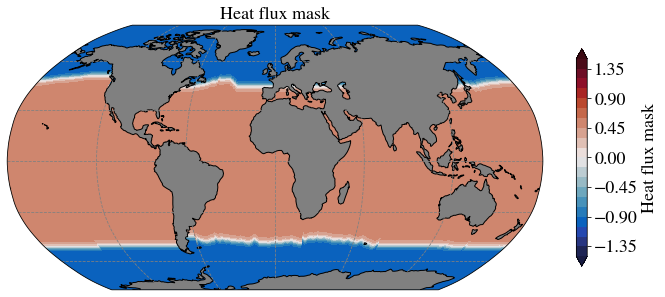

In [76]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1.5, 1.5, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, mask_heat_new, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Adding xticks
# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Heat flux mask', size = 18)
ax.set_title('Heat flux mask', size = 18)

#plt.savefig('Figures/heat_map_tanh.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

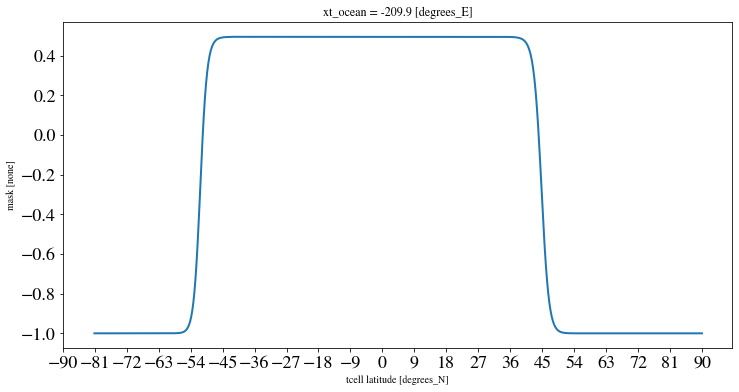

In [77]:
plt.figure(figsize = (12, 6))
mask_da.sel(xt_ocean = -210, method = 'nearest').plot()
plt.xticks(np.linspace(-90, 90, 21))
plt.show()

#plt.savefig('Figures/tanh_one_lon.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

## Saving mask to a netCDF file

In [78]:
mask_ds = mask_da.to_dataset()

#mask_ds.to_netcdf(path = '/scratch/x77/db6174/025deg_inputs/flux_forced_uniform_heat/heat_mask_interim.nc', mode = 'w', format = "NETCDF4", engine = "netcdf4")

In [79]:
area_t = cc.querying.getvar(expt = expt, session = session, variable = 'area_t', n = -1)
T = cc.querying.getvar(expt = expt, session = session, variable = 'temp', n = -1)
T = T.isel(st_ocean = 1).isel(time = 1)

In [80]:
#nc_file = '/scratch/x77/db6174/025deg_inputs/flux_forced_pos20W/heat_mask_interim.nc'
#nc_dataset = Dataset(nc_file, mode = 'r')
#mask_ds = xr.open_dataset(nc_file)
mask = mask_ds.mask

area_t = (area_t*T)/T

In [81]:
xt = np.arange(0, 1440)
yt = np.arange(0, 1080)

Y, X = np.meshgrid(yt,xt)

dy = 8
range_lat = 25

#y_mid = 500
#width = 75
y_mid = 499
width = 75

pos_val = h_max
neg_val = 0.0

mask_values = mask.values
mask_values[y_mid - width:y_mid + width, :] = 0
mask_values_new = mask.values

i = 200
j = 0
while j < 1440:
    i = 200
    while i < 800:
        if((mask_values_new[i, j]!=mask_values_new[i+1,j]) and (mask_values_new[i,j] == pos_val or mask_values_new[i,j] == neg_val) and (mask_values_new[i+1,j] == pos_val or mask_values_new[i+1,j] == neg_val)):
            if(mask_values_new[i,j] == pos_val and mask_values_new[i+1,j] == neg_val):
                mask_values_new[i-range_lat:i+range_lat,j] = np.tanh((-yt[i-range_lat:i+range_lat] + i)/dy)*(pos_val - neg_val)/2 + (pos_val - neg_val)/2
                i = i + 25
            elif(mask_values_new[i,j] == neg_val and mask_values_new[i+1,j] == pos_val):
                mask_values_new[i-range_lat:i+range_lat,j] = np.tanh((yt[i-range_lat:i+range_lat] - i)/dy)*(pos_val - neg_val)/2 + (pos_val - neg_val)/2
                i = i + 25
        i = i + 1
    j = j + 1

In [82]:
mask_new_da = xr.DataArray(mask_values_new, coords = [mask.yt_ocean, mask.xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'mask', attrs = {'units':'none'})

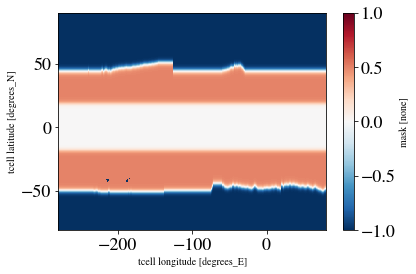

In [83]:
mask_new_da.plot()

In [84]:
mask_SH = mask_new_da.where(mask_new_da.yt_ocean < 0, 0)

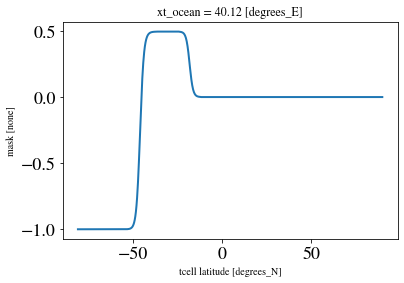

In [85]:
mask_SH.sel(xt_ocean = 40, method = 'nearest').plot()

In [86]:
mask_avg = (mask_SH*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
mask_avg.values

array(-0.00010837)

In [87]:
#from netCDF4 import Dataset
#mask_ds = (mask_NH * 10).to_dataset()
#mask_ds.to_netcdf(path = '/scratch/x77/db6174/025deg_inputs/flux_forced_pos10W_NH/heat_mask.nc', mode = 'w', format = "NETCDF4", engine = "netcdf4")#

In [88]:
from netCDF4 import Dataset
mask_ds = (mask_SH * 10).to_dataset()
mask_ds.to_netcdf(path = '/scratch/x77/db6174/025deg_inputs/flux_forced_pos10W_SH/heat_mask.nc', mode = 'w', format = "NETCDF4", engine = "netcdf4")